![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [15]:
# Celda 1
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=15)

In [16]:
y_pred = tree_predict(X_test, tree)

f1_arb_man = metrics.f1_score(y_pred, y_test)
acc_arb_man = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_arb_man)
print('Accuracy: ', acc_arb_man)

F1 Score:  0.9048757170172084
Accuracy:  0.8851039260969977


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [36]:
# Celda 2
n_estimators = 10
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

modelos = {}
for i, samp in enumerate(samples):
    modelos[i] = DecisionTreeClassifier(max_depth=6, random_state=seeds[i])
    modelos[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = modelos[i].predict(X_test)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [37]:
f1_bag_man = metrics.f1_score(y_pred, y_test)
acc_bag_man = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_bag_man)
print('Accuracy: ', acc_bag_man)

F1 Score:  0.9068709600191526
Accuracy:  0.8877020785219399


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [44]:
# Celda 3
bag_skl = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap=True,
                            max_features=round(np.log(X_train.shape[1])) ,random_state=123, n_jobs=-1, 
                            oob_score=True)

In [45]:
bag_skl.fit(X_train, y_train)
y_pred = bag_skl.predict(X_test)

f1_bag_skl = metrics.f1_score(y_pred, y_test)
acc_bag_skl = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_bag_skl)
print('Accuracy: ', acc_bag_skl)

F1 Score:  0.8608507570295602
Accuracy:  0.832852193995381


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [122]:
# Celda 4
rf_skl = RandomForestClassifier(max_depth=round(np.log(X_train.shape[1])), 
                                min_impurity_decrease=0.001, n_jobs=-1, 
                                random_state=123, oob_score=True)

rf_skl.fit(X_train, y_train)
y_pred = rf_skl.predict(X_test)

f1_rf_skl = metrics.f1_score(y_pred, y_test)
acc_rf_skl = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_rf_skl)
print('Accuracy: ', acc_rf_skl)

F1 Score:  0.8967301811338508
Accuracy:  0.8732678983833718


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

## Calibrando el n_estimators

In [48]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=estimator, random_state=123, 
                                 min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

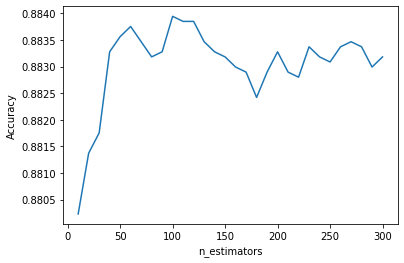

In [52]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [59]:
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo de estimadores es de ' + str(n_est_best))

El número óptimo de estimadores es de 100


## Calibrando el max depth

In [66]:
estimator_range = range(1,21)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=estimator, random_state=123, 
                                 min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

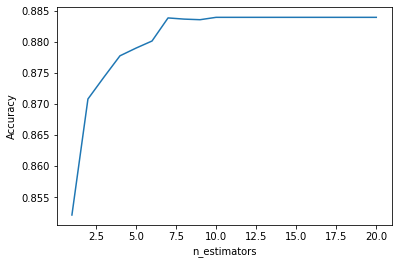

In [67]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [69]:
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo para la profundidad máxima de los arboles es de ' + str(n_est_best))

El número óptimo para la profundidad máxima de los arboles es de 10


Sin embargo se va a hacer uso de una profundidad máxima de 7, ya que se evidencia que el cambio entre esta profundidad máxima y en 10 tiene un cambio muy pequeño que podría estar afectamdo el tiempo computacional más de lo que le estaría aportando al modelo.

## Calibrando el max_features

In [73]:
estimator_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=123, 
                                 max_features= estimator, min_impurity_decrease=0.001, n_jobs=-1)
    accuracy_scores_rf.append(cross_val_score(clf_rf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

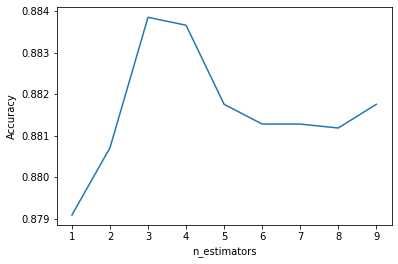

In [74]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [76]:
n_est_best = estimator_range[accuracy_scores_rf.index(max(accuracy_scores_rf))]
print('El número óptimo para el máximo de features de los arboles es de ' + str(n_est_best))

El número óptimo para el máximo de features de los arboles es de 3


El número óptimo de features a usar es de 3, el cuál es muy cercano al logartimo de la cantidad total de features en el set, lo cuál da un valor de 2.2

## Modelo con los parámetros optimizados

In [78]:
rf_skl_opt = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=123, 
                                 max_features= 3, min_impurity_decrease=0.001, n_jobs=-1)

rf_skl_opt.fit(X_train, y_train)
y_pred = rf_skl_opt.predict(X_test)

f1_rf_skl_opt = metrics.f1_score(y_pred, y_test)
acc_rf_skl_opt = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_rf_skl)
print('Accuracy: ', acc_rf_skl)

F1 Score:  0.8967301811338508
Accuracy:  0.8732678983833718


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [80]:
# Celda 6
xgb_skl = XGBClassifier()

xgb_skl.fit(X_train, y_train)
y_pred = xgb_skl.predict(X_test)

f1_xgb_skl = metrics.f1_score(y_pred, y_test)
acc_xgb_skl = metrics.accuracy_score(y_pred, y_test)

print('F1 Score: ', f1_rf_skl)
print('Accuracy: ', acc_rf_skl)

[12:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score:  0.8967301811338508
Accuracy:  0.8732678983833718


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

## Calibrando el learning rate

In [109]:
# Celda 7
estimator_range = range(0,20,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xgb = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_xgb = XGBClassifier(learning_rate = (estimator*0.05), random_state=123, n_jobs=-1)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

[13:11:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[13:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0, 0.5, 'Accuracy')

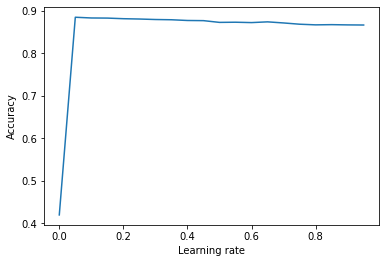

In [112]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
est_fin = [i*0.05 for i in estimator_range]
plt.plot(est_fin, accuracy_scores_xgb)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

In [113]:
n_est_best = estimator_range[accuracy_scores_xgb.index(max(accuracy_scores_xgb))]
print('El número óptimo para el learning rate de los arboles es de ' + str(n_est_best*0.05))

El número óptimo para el learning rate de los arboles es de 0.05


## Calibrando el gamma

In [123]:
estimator_range = range(0,20,1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_xgb = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf_xgb = XGBClassifier(learning_rate = 0.05, random_state=123, gamma = estimator,
                            n_jobs=-1)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

[16:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0, 0.5, 'Accuracy')

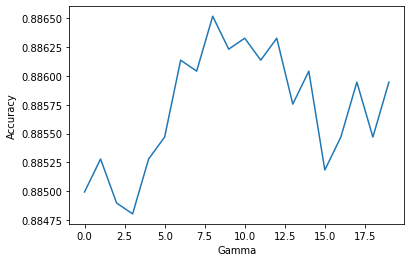

In [124]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
est_fin = [i for i in estimator_range]
plt.plot(est_fin, accuracy_scores_xgb)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')

In [125]:
n_est_best = estimator_range[accuracy_scores_xgb.index(max(accuracy_scores_xgb))]
print('El número óptimo para el gamma es de ' + str(n_est_best))

El número óptimo para el gamma es de 8


## Calibrando el colsample_bytree

In [126]:
estimator_range = range(1, X.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de colsample_bytree
for estimator in estimator_range:
    print(estimator)
    clf_xgb = XGBClassifier(learning_rate = 0.05, random_state=123, gamma = 8,
                            colsample_bytree = estimator, n_jobs=-1)
    accuracy_scores_xgb.append(cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy').mean())

1
[16:48:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_r

In [127]:
accuracy_scores_xgb

[0.884992853739876,
 0.8852787041448309,
 0.8848975702715579,
 0.8848022868032397,
 0.8852787041448309,
 0.8854692710814674,
 0.8861362553596951,
 0.8860409718913769,
 0.8865173892329681,
 0.8862315388280134,
 0.8863268222963315,
 0.8861362553596951,
 0.8863268222963316,
 0.8857551214864221,
 0.8860409718913769,
 0.8851834206765126,
 0.8854692710814673,
 0.8859456884230585,
 0.8854692710814674,
 0.8859456884230585,
 0.8865173892329681,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

ValueError: x and y must have same first dimension, but have shapes (9,) and (29,)

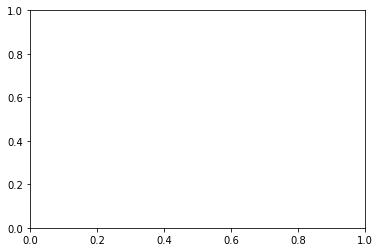

In [115]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores_xgb)
plt.xlabel('Colsample_bytree')
plt.ylabel('Accuracy')

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
